In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import folium
import shapely
import pyproj
import math
from shapely.ops import transform, Point, Polygon
from shapely.geometry import mapping

## original dataset value transformation

In [3]:
# read data and transform to wgs84

nyc_gdf = gpd.read_file('nycsquirrels_clean_1.csv')
nyc_gdf = gpd.GeoDataFrame(nyc_gdf, geometry=gpd.points_from_xy(nyc_gdf.long, nyc_gdf.lat))
nyc_gdf1 = nyc_gdf.set_crs('epsg:4326')

# convert fake bools (string) into 0s and 1s

behaviors = ['approaches', 'indifferent', 'runs_from', 
             'running', 'chasing', 'climbing', 'eating', 'foraging',
             'kuks', 'quaas', 'moans', 'tail_flags', 'tail_twitches']

bool_to_int = lambda x: 1 if x == 'TRUE' else 0

behavior_to_int = pd.DataFrame({behavior: nyc_gdf1[behavior].apply(bool_to_int) for behavior in behaviors})
nyc_gdf1.update(behavior_to_int)

# convert fake floats (string) to floats

long_float = nyc_gdf1['long'].apply(lambda x: float(x))
lat_float = nyc_gdf['lat'].apply(lambda x: float(x))

nyc_gdf1 = nyc_gdf1.assign(long = nyc_gdf1['long'].apply(lambda x: float(x)), 
                           lat = nyc_gdf['lat'].apply(lambda x: float(x)))
nyc_gdf1

long        lat unique_squirrel_id hectare shift      date  \
0    -73.957044  40.794851     37E-PM-1006-03     37E    PM  10062018   
1    -73.976831  40.766718      2E-AM-1010-03     02E    AM  10102018   
2    -73.975725  40.769703      5D-PM-1018-05     05D    PM  10182018   
3    -73.956570  40.790256     33H-AM-1019-02     33H    AM  10192018   
4    -73.971974  40.769305      6G-PM-1020-02     06G    PM  10202018   
...         ...        ...                ...     ...   ...       ...   
2963 -73.963943  40.790868     30B-AM-1007-04     30B    AM  10072018   
2964 -73.970402  40.782560     19A-PM-1013-05     19A    PM  10132018   
2965 -73.966587  40.783678     22D-PM-1012-07     22D    PM  10122018   
2966 -73.963994  40.789915     29B-PM-1010-02     29B    PM  10102018   
2967 -73.975479  40.769640      5E-PM-1012-01     05E    PM  10122018   

     hectare_squirrel_number       age primary_fur_color  \
0                          3     Adult              Gray   
1                          3     Adult          Cinnamon   
2                          5  Juvenile              Gray   
3                          2  Juvenile              Gray   
4                          2     Adult              Gray   
...                      ...       ...               ...   
2963                       4     Adult              Gray   
2964                       5     Adult              Gray   
2965                       7     Adult              Gray   
2966                       2                        Gray   
2967                       1     Adult          Cinnamon   

     combination_of_primary_and_highlight_color  ... tail_twitches approaches  \
0                                 Gray+Cinnamon  ...             0          0   
1                                     Cinnamon+  ...             0          0   
2                                         Gray+  ...             0          0   
3                                 Gray+Cinnamon  ...             0          0   
4                                         Gray+  ...             0          0   
...                                         ...  ...           ...        ...   
2963                                      Gray+  ...             0          0   
2964                                 Gray+White  ...             0          0   
2965                Gray+Black, Cinnamon, White  ...             0          0   
2966                       Gray+Cinnamon, White  ...             0          0   
2967                       Cinnamon+Gray, White  ...             0          1   

     indifferent runs_from                                      lat_long  \
0              0         1  POINT (-73.9570437717691 40.794850940803904)   
1              1         0   POINT (-73.9768311751004 40.76671780725581)   
2              0         1    POINT (-73.9757249834141 40.7697032606755)   
3              0         0    POINT (-73.9565700386162 40.7902561000937)   
4              1         0    POINT (-73.9719735582476 40.7693045133578)   
...          ...       ...                                           ...   
2963           0         1    POINT (-73.9639431360458 40.7908677445466)   
2964           1         0    POINT (-73.9704015859639 40.7825600069973)   
2965           1         0    POINT (-73.9665871993517 40.7836775064883)   
2966           1         0    POINT (-73.9639941227864 40.7899152327912)   
2967           0         0    POINT (-73.9754794191553 40.7696404489025)   

     community_districts borough_boundaries city_council_districts  \
0                     19                  4                     19   
1                     19                  4                     19   
2                     19                  4                     19   
3                     19                  4                     19   
4                     19                  4                     19   
...                  ...                ...                    ...   
2963                  19             

## add osm data

In [4]:
### load geojson datasets

centralpark_water_osm = gpd.read_file('geojson/water_cp.geojson')
centralpark_stream_osm = gpd.read_file('geojson/streams_cp.geojson')
centralpark_playg_osm = gpd.read_file('geojson/playgrounds_cp.geojson')
centralpark_paved_osm = gpd.read_file('geojson/paved.geojson')
centralpark_toilets_osm = gpd.read_file('geojson/toilets.geojson')
cp_northbd_osm = gpd.read_file('geojson/northbd.geojson') # cp north
cp_jorbd_osm = gpd.read_file('geojson/jorbd.geojson') # jacqueline kennedy onassis reservoir
cp_greatlawnbd_osm = gpd.read_file('geojson/greatlawnbd.geojson') # great lawn
cp_ramblebd_osm = gpd.read_file('geojson/ramblebd.geojson') # ramble
cp_southbd_osm = gpd.read_file('geojson/southbd.geojson') # cp south
met_osm = gpd.read_file('geojson/met.geojson') # the met
centralpark_gardens_osm = gpd.read_file('geojson/gardens_cp.geojson')
allwoodsosm = gpd.read_file('geojson/woods_cp.geojson').assign(feature_type = 'woods')
cp_baseball_osm = gpd.read_file('geojson/baseballpitch.geojson')
cp_field_osm = gpd.read_file('geojson/field.geojson')
allbarerockosm = gpd.read_file('geojson/bare_rock.geojson').assign(feature_type = 'bare_rock')
cp_pedestrian_osm = gpd.read_file('geojson/pedestrian.geojson')
cp_sportscenter_osm = gpd.read_file('geojson/sportscenter.geojson')

In [5]:
### data cleaning

drop_water_osm = ['relation/2389611', 'relation/2389521', 'relation/2389581', 
                  'relation/2389563','relation/2212963', 'way/608955193', 
                  'way/375673047', 'way/375673046', 'way/1024586392',
                  'way/727185210', 'way/727185216', 'way/727185221', 'way/727185214', 
                  'way/113690622', 'way/163470962', 'way/260910559', 'way/319615314', 
                  'way/319615316', 'way/394395237', 'way/394395238', 'way/470714268', 
                  'way/988718514', 'way/958630356']

drop_water_index = [centralpark_water_osm[centralpark_water_osm.get('id') == 
                                          water_id].index[0] 
                    for water_id in drop_water_osm]

cp_water_osm = centralpark_water_osm.drop(index=drop_water_index)

allwaterosm = pd.concat([cp_water_osm, centralpark_stream_osm])
allwaterosm = allwaterosm.reset_index().drop(columns = 'index')
water_feature_type = allwaterosm['natural'].fillna(allwaterosm['waterway'])
allwaterosm = allwaterosm.assign(feature_type = water_feature_type)


centralpark_playg_osm.at[23, 'name'] = 'Rudin Family Playground'
centralpark_playg_osm.at[50, 'name'] = 'Safari Playground'

cp_playgrounds_name = ['West 110th Street Playground', 'Tarr Family Playground', 
                       'Rudin Family Playground','Robert Bendheim Playground', 
                       'Tarr-Coyne Wild West Playground', '96th Street Playground', 
                       'Abraham and Joseph Spector Playground', 
                       'Arthur Ross Pinetum Playground', 
                       'Diana Ross Playground', 'Ancient Playground', 'Safari Playground',
                       'Ruth and Arthur Smadbeck-Heckscher East Playground', 
                       'Adventure Playground', 'Tarr-Coyne Tots Playground', 
                       'East 72nd Street Playground', 'Billy Johnson Playground', 
                       'Hecksher Playground', 'Mariner\'s Playground']

cp_playgrounds_index = [centralpark_playg_osm[centralpark_playg_osm.get('name') == 
                                              playground_name].index[0]
                        for playground_name in cp_playgrounds_name]

allplaygosm = centralpark_playg_osm.loc[cp_playgrounds_index].assign(feature_type = 'playground')


drop_paved_name = ['Park Avenue', 'Madison Avenue', 'Lexington Avenue', 
                   'York Avenue', 'FDR Drive', 
                   'Riverside Drive', 'West End Avenue', 
                   'Frederick Douglass Boulevard', 'Malcolm X Boulevard',
                   '8th Avenue', '7th Avenue', '6th Avenue', 
                   'East 106th Street', 'East 97th Street', 'East 96th Street', 
                   'East 86th Street', 'East 85th Street', 'East 84th Street', 
                   'East 79th Street',
                   'East 72nd Street', 'East 66th Street', 'East 65th Street',
                   'East 60th Street', 'East 59th Street',
                   'East 73rd Street', 'East 71st Street', 'East 61st Street',
                   'Cathedral Parkway', 'West 110th Street', 'West 106th Street', 
                   'West 96th Street', 
                   'West 95th Street', 'West 86th Street', 'West 81st Street', 
                   'West 79th Street', 
                   'West 75th Street', 'West 72nd Street', 'West 66th Street', 
                   'West 65th Street',
                   'West 62nd Street', 'West 54th Street', 'West 53rd Street']

drop_paved_index = []

for name in drop_paved_name:
    index_list = centralpark_paved_osm[centralpark_paved_osm.get('name') == name].index
    for index in index_list:
        drop_paved_index.append(index)
        
drop_5th_ends = ['way/988984235', 'way/195743336', 'way/422298615', 
                 'way/962626218', 'way/198924778',
                 'way/840996403', 'way/980855831', 'way/980855832', 
                 'way/980855833', 'way/22898583',
                 'way/46613661', 'way/5670874', 'way/167922075', 
                 'way/584850094', 'way/834058007', 'way/5673363', 'way/584850099']

for way in drop_5th_ends:
    drop_paved_index.append(centralpark_paved_osm[centralpark_paved_osm.get('id') == 
                                                  way].index[0])
    

allpavedosm = centralpark_paved_osm.drop(index = drop_paved_index).assign(feature_type = 'paved')



drop_toilets = ['node/2329911645', 'node/8539548031', 'node/1310874079', 
                'node/2339622631', 'way/266919662', 'way/668189108']

drop_toilets_index = [centralpark_toilets_osm[centralpark_toilets_osm.get('id') == 
                                              node].index[0]
                      for node in drop_toilets]

alltoiletsosm = centralpark_toilets_osm.drop(index = drop_toilets_index).assign(feature_type = 'toilet')



keepbd_columns = ['id', 'alt_name', 'amenity', 'building', 'height', 'name', 'geometry']

cp_northbd_id = ['way/39243913', 'way/278366155', 'way/278366170', 'way/118729389', 
                 'way/943419152',
                 'way/278366166', 'way/278366163', 'way/278366174']
cp_northbd_index = [cp_northbd_osm[cp_northbd_osm.get('id') == northbd_id].index[0] 
                    for northbd_id in cp_northbd_id]
allnorthbdosm = cp_northbd_osm.loc[cp_northbd_index].get(keepbd_columns)

cp_jorbd_id = ['way/278363031', 'way/817397167', 'way/278363044']
cp_jorbd_index = [cp_jorbd_osm[cp_jorbd_osm.get('id') == jorbd_id].index[0] 
                  for jorbd_id in cp_jorbd_id]
alljorbdosm = cp_jorbd_osm.loc[cp_jorbd_index].get(keepbd_columns)

cp_greatlawnbd_id = ['way/278363039', 'way/278363038', 'way/278363033', 
                     'way/278363041', 'way/278363029',
                     'way/278363036', 'way/278363065', 'way/278363049', 
                     'way/278363046', 'way/278363024', 
                     'way/278363048', 'way/278363035', 'way/278363053']
cp_greatlawnbd_index = [cp_greatlawnbd_osm[cp_greatlawnbd_osm.get('id') == 
                                           greatlawnbd_id].index[0] 
                        for greatlawnbd_id in cp_greatlawnbd_id]
allgreatlawnbdosm = cp_greatlawnbd_osm.loc[cp_greatlawnbd_index].get(keepbd_columns)

cp_ramblebd_id = ['way/278361406', 'way/278361407', 'way/775820359', 'relation/3698871', 
                  'way/354587581', 'way/354587583', 'way/265347581', 'way/265347585', 
                  'way/362647331', 'way/265347579', 'way/265347587']
cp_ramblebd_index = [cp_ramblebd_osm[cp_ramblebd_osm.get('id') == ramblebd_id].index[0] 
                     for ramblebd_id in cp_ramblebd_id]
allramblebdosm = cp_ramblebd_osm.loc[cp_ramblebd_index].get(keepbd_columns)

cp_southbd_id = ['way/265347589', 'way/585788256', 'way/265347597', 
                 'way/265347588', 'way/265347593',
                 'way/321166650', 'way/321166649', 'way/265347596', 
                 'way/265347590', 'way/265347591',
                 'way/385442739', 'way/265347586', 'way/265347592']
cp_southbd_index = [cp_southbd_osm[cp_southbd_osm.get('id') == southbd_id].index[0] 
                    for southbd_id in cp_southbd_id]
allsouthbdosm = cp_southbd_osm.loc[cp_southbd_index].get(keepbd_columns)

allmetosm = met_osm[met_osm.get('name') == 'The Metropolitan Museum of Art']

allbuildingosm = pd.concat([allnorthbdosm, alljorbdosm, allgreatlawnbdosm, 
                            allramblebdosm, allsouthbdosm, allmetosm]).assign(feature_type = 'building')


drop_garden = ['way/362826846', 'way/169915675', 'way/330448922', 
               'way/313994014', 'way/202503285',
               'way/225189389', 'way/796333282', 'way/225188744']

drop_garden_index = [centralpark_gardens_osm[centralpark_gardens_osm.get('id') == 
                                             way].index[0] 
                     for way in drop_garden]
    
allgardenosm = centralpark_gardens_osm.drop(index = drop_garden_index).assign(feature_type = 'garden')



drop_baseball = ['way/667343443', 'way/920569850', 'way/920569847', 'way/319797239']

drop_baseball_index = [cp_baseball_osm[cp_baseball_osm.get('id')
                                       == way].index[0] for way in drop_baseball]

allbaseballosm = cp_baseball_osm.drop(index = drop_baseball_index).assign(feature_type = 'pitch: baseball')


drop_field = ['way/188692199', 'way/951525207', 'way/951525216', 'way/951525219', 
              'way/951539223', 'way/951539207', 'way/951539204', 'way/951539221', 
              'way/951539203', 'way/951539215',
              'way/951539218', 'way/951525211', 'way/951539232', 'way/951525215', 
              'way/951525217',
              'way/951539196', 'way/951525222', 'way/951525209', 'way/972597724',
              'way/949457222', 'way/949457226', 'way/953189819', 'way/849307005', 
              'way/849307011', 'way/849307012',
              'way/849307006', 'way/952333244', 'way/849307009', 'way/953189823', 
              'way/952333240', 'way/949532332',
              'way/949848463', 'way/949851336', 'way/667981482', 'way/949848467', 
              'way/949848466',
              'way/833371440', 'way/949848471', 'way/949848459', 'way/949848457',
              'way/849046450', 'way/849046418', 'way/849046432', 'way/849046434', 
              'way/849046451',
              'way/849046431', 'way/849046424', 'way/849046433', 'way/849046423', 
              'way/667981479', 'way/667981483',
              'way/667981480', 'way/849046437', 'way/849046453', 'way/849046448', 
              'way/849046420',
              'way/849046440', 'way/849046435', 'way/849046417', 'way/849299252', 
              'way/849299251', 'way/949848465',
              'way/849046452', 'way/849046454', 'way/849046415', 'way/667981478', 
              'way/849046438', 'way/849046427',
              'way/849046421', 'way/849046429', 'way/849046457', 'way/849046428',
              'way/849046444', 'way/849046441', 'way/849046426', 'way/849046414', 
              'way/949848462']

drop_field_index = [cp_field_osm[cp_field_osm.get('id') == way].index[0] 
                    for way in drop_field]

allgrassosm = cp_field_osm.drop(index = drop_field_index).assign(feature_type = 'grass')


drop_ped = ['relation/4623434', 'relation/4623433', 'relation/4623431', 
            'way/1031859264', 'way/321166645',
            'relation/2280942', 'way/329988122', 'way/329988123', 
            'way/458452177', 'way/710571385', 
            'way/375314249', 'way/338043682', 'way/46340036', 'way/710571377', 'way/5671777']

drop_ped_index = [cp_pedestrian_osm[cp_pedestrian_osm.get('id') == ped].index[0] 
                  for ped in drop_ped]

allpedestrianosm = cp_pedestrian_osm.drop(index=drop_ped_index).assign(feature_type = 'pedestrian')


drop_spcenter = ['node/368062558', 'node/2724236668', 'node/5607297102']

drop_spcenter_index = [cp_sportscenter_osm[cp_sportscenter_osm.get('id') 
                                           == spcenter].index[0] 
                       for spcenter in drop_spcenter]

allspcenterosm = cp_sportscenter_osm.drop(index=drop_spcenter_index).assign(feature_type = 'sports center')

## `centralparkallfeaturesmap` : map all features with legend and tag

In [6]:
# remove nodes (area unknown --> buffer unknown)

dataframes = [allbuildingosm, allgardenosm, allgrassosm, allpedestrianosm, allwaterosm, allwoodsosm,
              allpavedosm, allbaseballosm, allplaygosm, allspcenterosm, allbarerockosm, alltoiletsosm]

check_node = lambda x: 0 if 'node' in x else 1

for df in dataframes:
    print([osm_id for osm_id in df.get('id') if 'node' in osm_id])
    
allgardenosm = allgardenosm.assign(node = allgardenosm.get('id').apply(check_node))
allgardenosm = allgardenosm[allgardenosm.get('node') == 1]
allplaygosm = allplaygosm.assign(node = allplaygosm.get('id').apply(check_node))
allplaygosm = allplaygosm[allplaygosm.get('node') == 1]
alltoiletsosm = alltoiletsosm.assign(node = alltoiletsosm.get('id').apply(check_node))
alltoiletsosm = alltoiletsosm[alltoiletsosm.get('node') == 1]

nodeless_dataframes = [allbuildingosm, allgardenosm, allgrassosm, allpedestrianosm, allwaterosm, allwoodsosm,
                       allpavedosm, allbaseballosm, allplaygosm, allspcenterosm, allbarerockosm, alltoiletsosm]

for df in nodeless_dataframes:
    print([osm_id for osm_id in df.get('id') if 'node' in osm_id])

[]
['node/1240900859', 'node/1240900865', 'node/1240901075']
[]
[]
[]
[]
[]
[]
['node/1203806251', 'node/1209744496']
[]
[]
['node/322546340', 'node/348454463', 'node/410224440', 'node/1240900887', 'node/1240900893', 'node/1740891617', 'node/1740891627', 'node/1754595065', 'node/2312963423', 'node/3003918339', 'node/3669154898', 'node/3720680317', 'node/3720681566', 'node/3720681573', 'node/3720682054', 'node/9411185887']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


In [7]:
centralparkallfeatures = pd.concat(nodeless_dataframes)[['id', 'geometry', 'name', 'feature_type']]
centralparkfeatures = centralparkallfeatures.reset_index().drop(columns='index')

feature_is_building = (centralparkfeatures['feature_type'] == 'building')
feature_is_garden = (centralparkfeatures['feature_type'] == 'garden')
feature_is_grass = (centralparkfeatures['feature_type'] == 'grass')
feature_is_pedestrian = (centralparkfeatures['feature_type'] == 'pedestrian')
feature_is_water = (centralparkfeatures['feature_type'] == 'water')
feature_is_stream = (centralparkfeatures['feature_type'] == 'stream')
feature_is_woods = (centralparkfeatures['feature_type'] == 'woods')

centralparkfeatures = centralparkfeatures[(feature_is_building) | (feature_is_garden) | (feature_is_grass) | 
                                          (feature_is_pedestrian) | (feature_is_water) | (feature_is_stream) |
                                          (feature_is_woods)]
centralparkfeatures

id                                           geometry  \
0     way/39243913  POLYGON ((-73.95635 40.79872, -73.95635 40.798...   
1    way/278366155  POLYGON ((-73.95138 40.79711, -73.95136 40.797...   
2    way/278366170  POLYGON ((-73.95909 40.79729, -73.95902 40.797...   
3    way/118729389  POLYGON ((-73.95524 40.79639, -73.95523 40.796...   
4    way/943419152  POLYGON ((-73.95141 40.79469, -73.95135 40.794...   
..             ...                                                ...   
172  way/386482336  POLYGON ((-73.95227 40.79437, -73.95232 40.794...   
173  way/386482338  POLYGON ((-73.95177 40.79446, -73.95176 40.794...   
174  way/386482340  POLYGON ((-73.95293 40.79374, -73.95298 40.793...   
175  way/387382854  POLYGON ((-73.95579 40.79606, -73.95686 40.796...   
176  way/430633035  POLYGON ((-73.95181 40.79451, -73.95179 40.794...   

                      name feature_type  
0           The Blockhouse     building  
1    Dana Discovery Center     building  
2                     None     building  
3                     None     building  
4                     None     building  
..                     ...          ...  
172                   None        woods  
173                   None        woods  
174                   None        woods  
175             The Ravine        woods  
176                   None        woods  

[177 rows x 4 columns]

In [8]:
fillOp = 0.6

building = folium.GeoJson(allbuildingosm, name='building',
               style_function=lambda x: {'color': '#ad6f03', 'fillOpacity': fillOp})

garden = folium.GeoJson(allgardenosm, name='garden',
               style_function=lambda x: {'color': '#ff8cec', 'fillOpacity': fillOp})

grass = folium.GeoJson(allgrassosm, name='grass', 
               style_function=lambda x: {'color': '#86b35d', 'fillOpacity': fillOp})

pedestrian = folium.GeoJson(allpedestrianosm, name='pedestrian',
               style_function=lambda x: {'color': '#000000', 'fillOpacity': fillOp})

water = folium.GeoJson(allwaterosm, name='water', 
               style_function=lambda x: {'color': '#1795e8', 'fillOpacity': fillOp})

woods = folium.GeoJson(allwoodsosm, name='woods',
               style_function=lambda x: {'color': '#098f57', 'fillOpacity': fillOp})

baseball = folium.GeoJson(allbaseballosm, name='baseball',
                          style_function=lambda x: {'color': '#e0cdb4', 'fillOpacity': fillOp})

playground = folium.GeoJson(allplaygosm, name='playground',
                            style_function=lambda x: {'color': '#f5931b', 'fillOpacity': fillOp})

paved = folium.GeoJson(allpavedosm, name='paved',
                       style_function=lambda x: {'color': '#000000', 'fillOpacity': fillOp})

sportscenter = folium.GeoJson(allspcenterosm, name='sports center',
                              style_function=lambda x: {'color': '#960000', 'fillOpacity': fillOp})

rock = folium.GeoJson(allbarerockosm, name='rock',
                      style_function=lambda x: {'color': '#525252', 'fillOpacity': fillOp})

toilet = folium.GeoJson(alltoiletsosm, name='toilet',
                        style_function=lambda x: {'color': '#103b91', 'fillOpacity': fillOp})

In [9]:
centralparkallfeaturesmap = folium.Map(location = [40.7823, -73.96600], 
                                       zoom_start = 14, 
                                       min_zoom = 14,
                                       tiles = 'cartodbpositron', 
                                       control_scale = True)

building.add_to(centralparkallfeaturesmap)
garden.add_to(centralparkallfeaturesmap)
grass.add_to(centralparkallfeaturesmap)
pedestrian.add_to(centralparkallfeaturesmap)
water.add_to(centralparkallfeaturesmap)
woods.add_to(centralparkallfeaturesmap)
baseball.add_to(centralparkallfeaturesmap)
playground.add_to(centralparkallfeaturesmap)
paved.add_to(centralparkallfeaturesmap)
sportscenter.add_to(centralparkallfeaturesmap)
rock.add_to(centralparkallfeaturesmap)
toilet.add_to(centralparkallfeaturesmap)

folium.LayerControl().add_to(centralparkallfeaturesmap)
centralparkallfeaturesmap

In [10]:
cpimap = folium.Map(location = [40.7823, -73.96600], 
                    zoom_start = 14, 
                    min_zoom = 14,
                    tiles = 'cartodbpositron', 
                    control_scale = True)

building.add_to(cpimap)
garden.add_to(cpimap)
grass.add_to(cpimap)
pedestrian.add_to(cpimap)
water.add_to(cpimap)
woods.add_to(cpimap)

folium.LayerControl().add_to(cpimap)
cpimap

## buffers - squirrels *near* feature

In [11]:
# remove squirrels outside central park

centralpark_perimeter = allpavedosm[(allpavedosm.get('name') == '5th Avenue') |
                                    (allpavedosm.get('name') == 'Central Park North') |
                                    (allpavedosm.get('name') == 'Central Park West') |
                                    (allpavedosm.get('name') == 'Central Park South') |
                                    (allpavedosm.get('name') == 'Grand Army Plaza') |
                                    (allpavedosm.get('name') == 'Doris C. Freedman Place') |
                                    (allpavedosm.get('name') == 'Duke Ellington Circle')]

centralparkperimeter = centralpark_perimeter.unary_union.convex_hull

squirrelinside = nyc_gdf1.within(centralparkperimeter)
nyc_gdf1 = nyc_gdf1.assign(inside = squirrelinside)
nyc_gdf1 = nyc_gdf1[nyc_gdf1.get('inside') == True]

In [12]:
check_relation = lambda x: 0 if 'relation' in x else 1
print([osm_id for osm_id in centralparkfeatures.get('id') if 'relation' in osm_id])

['relation/3698871', 'relation/3698894', 'relation/7896090', 'relation/2067899', 'relation/3170084', 'relation/7896089', 'relation/7896105', 'relation/166150', 'relation/2155107', 'relation/7895705', 'relation/7893963', 'relation/11525699', 'relation/11525718']


<AxesSubplot:ylabel='Frequency'>

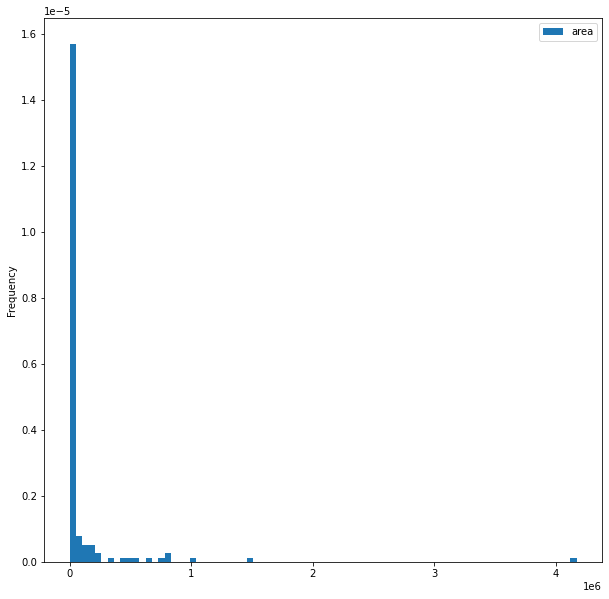

In [23]:
# area of each polygon 

polygon_area = centralparkfeatures.to_crs('epsg:2263').geometry.area
relation_length = centralparkfeatures.to_crs('epsg:2263').geometry.length
centralparkfeatures = centralparkfeatures.assign(area = polygon_area)
centralparkfeatures = centralparkfeatures.assign(length = relation_length)
centralparkfeatures[centralparkfeatures.get('area') > 0].plot.hist(column=['area'], 
                                                                   density = True, 
                                                                   figsize=(10,10),
                                                                   bins=80)

In [26]:
centralparkfeatures[centralparkfeatures['feature_type'] == 'stream']

id                                           geometry  \
155  way/104336115  LINESTRING (-73.95817 40.79357, -73.95806 40.7...   
156  way/104336130  LINESTRING (-73.95965 40.79479, -73.95964 40.7...   
157  way/431227166  LINESTRING (-73.97268 40.77931, -73.97267 40.7...   
158  way/431227168  LINESTRING (-73.96907 40.77728, -73.96911 40.7...   
159  way/431227173  LINESTRING (-73.96937 40.77714, -73.96937 40.7...   
160  way/689009138  LINESTRING (-73.96936 40.77715, -73.96937 40.7...   
161  way/784188865  LINESTRING (-73.95806 40.79373, -73.95804 40.7...   

         name feature_type  area       length  
155      None       stream   0.0    66.548825  
156  The Loch       stream   0.0  1414.242649  
157      None       stream   0.0   306.948349  
158  The Gill       stream   0.0    96.190900  
159  The Gill       stream   0.0   834.228508  
160  The Gill       stream   0.0     5.850414  
161      None       stream   0.0   338.173060

In [ ]:
features = ['building', 'garden', 'grass', 'pedestrian', 'water', 'woods']

In [118]:
geospatial_analysis = ['nearbuilding', 'neargarden', 'neargrass', 'nearpedestrian', 'nearwater', 'nearwoods']
buffer_counts = pd.DataFrame(columns = ['buffer'] + geospatial_analysis)

for i in range(12, 41, 1):
    factor = i/10
    buffer_counter = [0]

    def calculate_buffer(area):
        cap = 200
        buffer_counter[0] = factor
        if area == 0:
            return 50
        math_func = math.pow(area, 0.4) * factor
        if math_func > cap:
            return cap
        return math_func

    spec_buffer = centralparkfeatures.get('area').apply(calculate_buffer)
    centralparkfeatures = centralparkfeatures.assign(buffer_radius = spec_buffer)

    # customized buffers

    test_map = folium.Map(location = [40.7823, -73.96600], 
                          zoom_start = 14, 
                          min_zoom = 14,
                          tiles = 'cartodbpositron', 
                          control_scale = True)

    planar_nyc_gdf1 = nyc_gdf1.to_crs('epsg:2263')


    ######## building buffer ########

    building_polygons = centralparkfeatures[centralparkfeatures.get('feature_type') 
                                            == 'building'].to_crs('epsg:2263').reset_index()
    building_ind_buffer = np.array([])

    for i in range(len(building_polygons)):
        building_ind_buffer = np.append(building_ind_buffer, 
                                    building_polygons.geometry[i].buffer(
                                        building_polygons['buffer_radius'][i]))

    building_polygons = building_polygons.assign(buffer = building_ind_buffer)
    building_buffer_gpd = gpd.GeoDataFrame(geometry=building_ind_buffer)
    planar_building_buffer = building_buffer_gpd.geometry.unary_union


    ######## garden buffer ########

    garden_polygons = centralparkfeatures[centralparkfeatures.get('feature_type')
                                          == 'garden'].to_crs('epsg:2263').reset_index()
    garden_ind_buffer = np.array([])

    for i in range(len(garden_polygons)):
        garden_ind_buffer = np.append(garden_ind_buffer, 
                                    garden_polygons.geometry[i].buffer(
                                        garden_polygons['buffer_radius'][i]))
    garden_polygons = garden_polygons.assign(buffer = garden_ind_buffer)
    garden_buffer_gpd = gpd.GeoDataFrame(geometry=garden_ind_buffer)
    planar_garden_buffer = garden_buffer_gpd.geometry.unary_union


    ######## grass buffer ########

    grass_polygons = centralparkfeatures[centralparkfeatures.get('feature_type')
                                          == 'grass'].to_crs('epsg:2263').reset_index()
    grass_ind_buffer = np.array([])

    for i in range(len(grass_polygons)):
        grass_ind_buffer = np.append(grass_ind_buffer, 
                                    grass_polygons.geometry[i].buffer(
                                        grass_polygons['buffer_radius'][i]))
    grass_polygons = grass_polygons.assign(buffer = grass_ind_buffer)
    grass_buffer_gpd = gpd.GeoDataFrame(geometry=grass_ind_buffer)
    planar_grass_buffer = grass_buffer_gpd.geometry.unary_union


    ######## pedestrian buffer ########

    pedestrian_polygons = centralparkfeatures[centralparkfeatures.get('feature_type')
                                               == 'pedestrian'].to_crs('epsg:2263').reset_index()
    pedestrian_ind_buffer = np.array([])

    for i in range(len(pedestrian_polygons)):
        pedestrian_ind_buffer = np.append(pedestrian_ind_buffer,
                                         pedestrian_polygons.geometry[i].buffer(
                                             pedestrian_polygons['buffer_radius'][i]))
    pedestrian_polygons = pedestrian_polygons.assign(buffer = pedestrian_ind_buffer)
    pedestrian_buffer_gpd = gpd.GeoDataFrame(geometry=pedestrian_ind_buffer)
    planar_pedestrian_buffer = pedestrian_buffer_gpd.geometry.unary_union


    ######## polyline buffer (pedestrian and stream) ########


    ######## water buffer ########

    water_polygons = centralparkfeatures[(centralparkfeatures.get('feature_type') == 'water') |
                                         (centralparkfeatures.get('feature_type') == 'stream')].to_crs('epsg:2263').reset_index()
    water_ind_buffer = np.array([])

    for i in range(len(water_polygons)):
        water_ind_buffer = np.append(water_ind_buffer,
                                     water_polygons.geometry[i].buffer(water_polygons['buffer_radius'][i]))
    water_polygons = water_polygons.assign(buffer = water_ind_buffer)
    water_buffer_gpd = gpd.GeoDataFrame(geometry=water_ind_buffer)
    planar_water_buffer = water_buffer_gpd.geometry.unary_union


    ######## woods buffer ########

    woods_polygons = centralparkfeatures[centralparkfeatures.get('feature_type') 
                                         == 'woods'].to_crs('epsg:2263').reset_index()
    woods_ind_buffer = np.array([])

    for i in range(len(woods_polygons)):
        woods_ind_buffer = np.append(woods_ind_buffer,
                                     woods_polygons.geometry[i].buffer(woods_polygons['buffer_radius'][i]))
    woods_polygons = woods_polygons.assign(buffer = woods_ind_buffer)
    woods_buffer_gpd = gpd.GeoDataFrame(geometry=woods_ind_buffer)
    planar_woods_buffer = woods_buffer_gpd.geometry.unary_union

    ######## transform and map ########

    buffercrs = pyproj.CRS('epsg:2263')
    regcrs = pyproj.CRS('epsg:4326')
    project = pyproj.Transformer.from_crs(buffercrs, regcrs, always_xy=True).transform

    building_buffer = transform(project, planar_building_buffer)
    garden_buffer = transform(project, planar_garden_buffer)
    grass_buffer = transform(project, planar_grass_buffer)
    pedestrian_buffer = transform(project, planar_pedestrian_buffer)
    water_buffer = transform(project, planar_water_buffer)
    woods_buffer = transform(project, planar_woods_buffer)

    folium.GeoJson(building_buffer, name = 'building buffer').add_to(test_map)
    folium.GeoJson(garden_buffer, name = 'garden buffer').add_to(test_map)
    folium.GeoJson(grass_buffer, name = 'grass buffer').add_to(test_map)
    folium.GeoJson(pedestrian_buffer, name = 'pedestrian buffer').add_to(test_map)
    folium.GeoJson(water_buffer, name = 'water buffer').add_to(test_map)
    folium.GeoJson(woods_buffer, name = 'woods buffer').add_to(test_map)

    building.add_to(test_map)
    garden.add_to(test_map)
    grass.add_to(test_map)
    pedestrian.add_to(test_map)
    water.add_to(test_map)
    woods.add_to(test_map)

    folium.LayerControl().add_to(test_map)

    # test_map

    planar_buffers = [planar_building_buffer, planar_garden_buffer, planar_grass_buffer, planar_pedestrian_buffer,
                     planar_water_buffer, planar_woods_buffer]

    for i in range(len(geospatial_analysis)):
        nyc_gdf1[geospatial_analysis[i]] = planar_nyc_gdf1.within(planar_buffers[i])

    counts = np.array([buffer_counter])
    for condition in geospatial_analysis:
        counts = np.append(counts, sum(nyc_gdf1[condition]))
    buffer_counts.loc[len(buffer_counts.index)] = counts
    
buffer_counts

buffer  nearbuilding  neargarden  neargrass  nearpedestrian  nearwater  \
0      0.1           1.0       103.0      202.0            30.0       50.0   
1      0.2           5.0       104.0      204.0            30.0       52.0   
2      0.3           5.0       106.0      205.0            30.0       52.0   
3      0.4           5.0       106.0      206.0            30.0       52.0   
4      0.5           8.0       106.0      206.0            30.0       54.0   
5      0.6           8.0       106.0      207.0            32.0       54.0   
6      0.7           9.0       107.0      208.0            32.0       55.0   
7      0.8           9.0       107.0      212.0            32.0       58.0   
8      0.9           9.0       107.0      213.0            33.0       64.0   
9      1.0           9.0       108.0      215.0            33.0       68.0   
10     1.1          11.0       108.0      218.0            34.0       74.0   
11     1.2          11.0       109.0      223.0            34.0       78.0   
12     1.3          11.0       109.0      225.0            34.0       84.0   
13     1.4          12.0       109.0      234.0            35.0       86.0   
14     1.5          13.0       109.0      238.0            36.0       89.0   
15     1.6          13.0       109.0      241.0            37.0       94.0   
16     1.7          13.0       110.0      242.0            37.0      100.0   
17     1.8          14.0       110.0      246.0            37.0      106.0   
18     1.9          15.0       111.0      248.0            37.0      114.0   
19     2.0          17.0       112.0      251.0            37.0      120.0   
20     2.1          19.0       112.0      257.0            37.0      125.0   
21     2.2          20.0       113.0      261.0            37.0      129.0   
22     2.3          22.0       113.0      271.0            37.0      131.0   
23     2.4          23.0       113.0      277.0            37.0      135.0   
24     2.5          25.0       113.0      280.0            37.0      139.0   
25     2.6          26.0       114.0      289.0            37.0      139.0   
26     2.7          28.0       114.0      293.0            37.0      145.0   
27     2.8          28.0       114.0      300.0            37.0      153.0   
28     2.9          28.0       114.0      305.0            37.0      155.0   
29     3.0          30.0       114.0      310.0            37.0      160.0   
30     3.1          31.0       115.0      317.0            38.0      166.0   
31     3.2          32.0       115.0      321.0            38.0      171.0   
32     3.3          33.0       116.0      331.0            38.0      173.0   
33     3.4          35.0       116.0      334.0            40.0      177.0   
34     3.5          38.0       117.0      337.0            40.0      181.0   
35     3.6          40.0       118.0      339.0            40.0      183.0   
36     3.7          40.0       119.0      341.0            40.0      186.0   
37     3.8          41.0       119.0      345.0            40.0      193.0   
38     3.9          41.0       119.0      349.0            41.0      196.0   
39     4.0          42.0       120.0      351.0            41.0      201.0   

    nearwoods  
0       511.0  
1       512.0  
2       512.0  
3       515.0  
4       517.0  
5       520.0  
6       520.0  
7       523.0  
8       525.0  
9       527.0  
10      529.0  
11      530.0  
12      531.0  
13      531.0  
14      532.0  
15      532.0  
16      532.0  
17      532.0  
18      532.0  
19      532.0  
20      534.0  
21      534.0  
22      534.0  
23      535.0  
24      536.0  
25      538.0  
26      538.0  
27      540.0  
28      542.0  
29      543.0  
30      545.0  
31      548.0  
32      550.0  
33      551.0  
34      553.0  
35      556.0  
36      558.0  
37      559.0  
38      562.0  
39      563.0

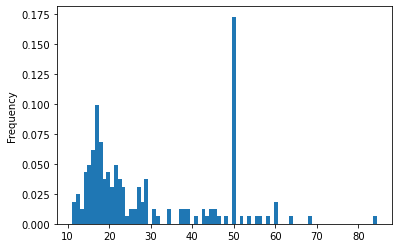

In [119]:
centralparkfeatures['buffer_radius'].plot.hist(density=True, bins=80);

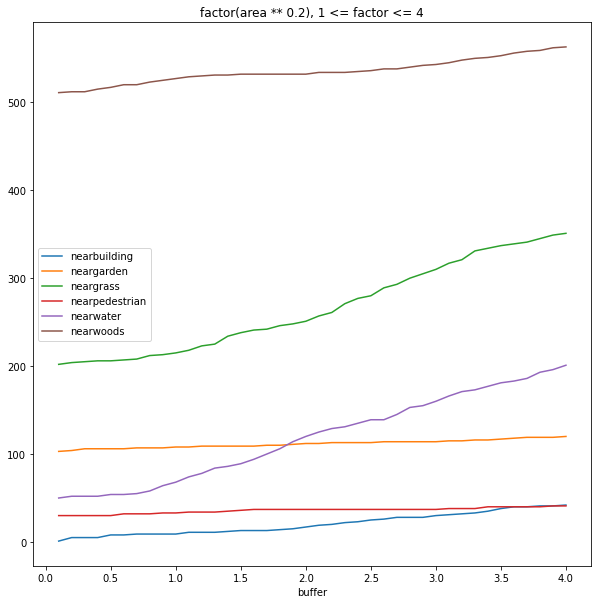

In [120]:
buffer_counts.plot(x = 'buffer', figsize = (10, 10), title = 'factor(area ** 0.2), 1 <= factor <= 4');

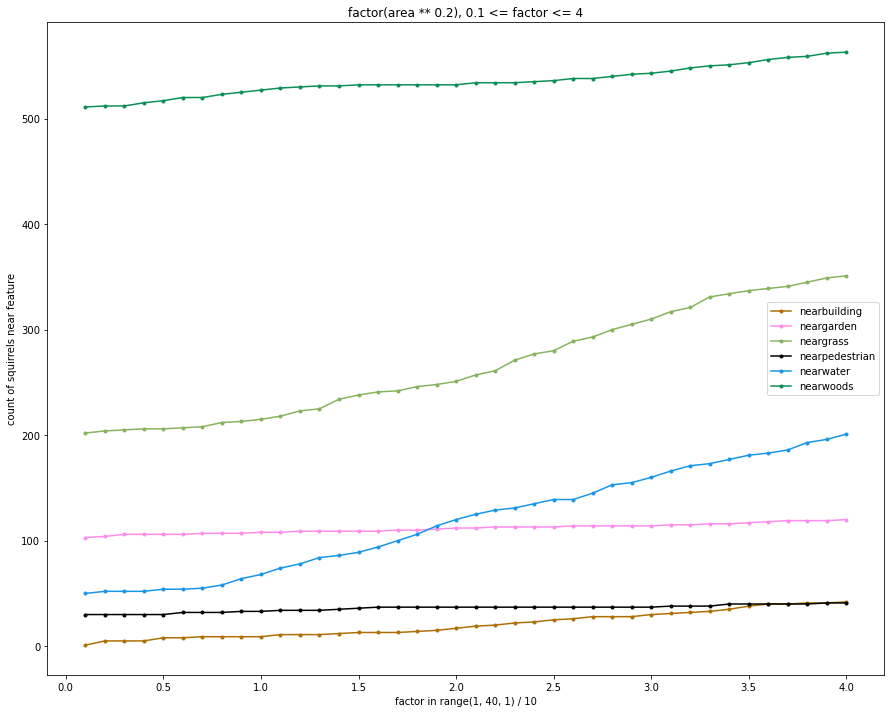

In [121]:
plt.figure(figsize=(15,12))
plt.ylabel('count of squirrels near feature')
plt.title('factor(area ** 0.2), 0.1 <= factor <= 4')
plt.xlabel('factor in range(1, 40, 1) / 10')
plt.plot(buffer_counts['buffer'], buffer_counts['nearbuilding'], c='#ad6f03', marker='.', label='nearbuilding')
plt.plot(buffer_counts['buffer'], buffer_counts['neargarden'], c='#ff8cec', marker='.', label = 'neargarden')
plt.plot(buffer_counts['buffer'], buffer_counts['neargrass'], c='#86b35d', marker='.', label='neargrass')
plt.plot(buffer_counts['buffer'], buffer_counts['nearpedestrian'], c='#000000', marker='.', label='nearpedestrian')
plt.plot(buffer_counts['buffer'], buffer_counts['nearwater'], c='#1795e8', marker='.', label='nearwater')
plt.plot(buffer_counts['buffer'], buffer_counts['nearwoods'], c='#098f57', marker='.', label='nearwoods')
plt.legend()
plt.savefig('bufferradiuscomparison/0.2_power.png', bbox_inches='tight')
plt.show()

In [122]:
buffer_counts.to_csv('bufferradiuscomparison/0.2_power.csv')

In [94]:
centralparkfeatures

id                                           geometry  \
0     way/39243913  POLYGON ((-73.95635 40.79872, -73.95635 40.798...   
1    way/278366155  POLYGON ((-73.95138 40.79711, -73.95136 40.797...   
2    way/278366170  POLYGON ((-73.95909 40.79729, -73.95902 40.797...   
3    way/118729389  POLYGON ((-73.95524 40.79639, -73.95523 40.796...   
4    way/943419152  POLYGON ((-73.95141 40.79469, -73.95135 40.794...   
..             ...                                                ...   
172  way/386482336  POLYGON ((-73.95227 40.79437, -73.95232 40.794...   
173  way/386482338  POLYGON ((-73.95177 40.79446, -73.95176 40.794...   
174  way/386482340  POLYGON ((-73.95293 40.79374, -73.95298 40.793...   
175  way/387382854  POLYGON ((-73.95579 40.79606, -73.95686 40.796...   
176  way/430633035  POLYGON ((-73.95181 40.79451, -73.95179 40.794...   

                      name feature_type           area       length  \
0           The Blockhouse     building    1103.375158   132.868602   
1    Dana Discovery Center     building    3877.393835   287.185515   
2                     None     building     429.231598    82.873143   
3                     None     building   12006.964830   560.765916   
4                     None     building     354.731725    75.615728   
..                     ...          ...            ...          ...   
172                   None        woods   20964.548676   852.143647   
173                   None        woods    2050.711383   278.641558   
174                   None        woods    6675.706123   535.881373   
175             The Ravine        woods  783295.898571  4170.913285   
176                   None        woods    2106.877737   286.155293   

     buffer_radius  
0        28.024516  
1        33.051674  
2        24.247987  
3        37.572969  
4        23.485447  
..             ...  
172      39.802353  
173      30.503768  
174      35.224921  
175      54.285063  
176      30.611850  

[177 rows x 7 columns]

In [139]:
factor = 1.2
buffer_counter = [0]

def calculate_buffer(area):
    cap = 200
    buffer_counter[0] = factor
    if area == 0:
        return 50
    math_func = math.pow(area, 0.4) * factor
    if math_func > cap:
        return cap
    return math_func

spec_buffer = centralparkfeatures.get('area').apply(calculate_buffer)
centralparkfeatures = centralparkfeatures.assign(buffer_radius = spec_buffer)

# customized buffers

test_map = folium.Map(location = [40.7823, -73.96600], 
                      zoom_start = 14, 
                      min_zoom = 14,
                      tiles = 'cartodbpositron', 
                      control_scale = True)

planar_nyc_gdf1 = nyc_gdf1.to_crs('epsg:2263')


######## building buffer ########
building_polygons = centralparkfeatures[centralparkfeatures.get('feature_type') 
                                            == 'building'].to_crs('epsg:2263').reset_index()
building_ind_buffer = np.array([])

for i in range(len(building_polygons)):
    building_ind_buffer = np.append(building_ind_buffer, 
                                    building_polygons.geometry[i].buffer(
                                        building_polygons['buffer_radius'][i]))

building_polygons = building_polygons.assign(buffer = building_ind_buffer)
building_buffer_gpd = gpd.GeoDataFrame(geometry=building_ind_buffer)
planar_building_buffer = building_buffer_gpd.geometry.unary_union


######## garden buffer ########

garden_polygons = centralparkfeatures[centralparkfeatures.get('feature_type')
                                          == 'garden'].to_crs('epsg:2263').reset_index()
garden_ind_buffer = np.array([])

for i in range(len(garden_polygons)):
    garden_ind_buffer = np.append(garden_ind_buffer, 
                                    garden_polygons.geometry[i].buffer(
                                        garden_polygons['buffer_radius'][i]))
garden_polygons = garden_polygons.assign(buffer = garden_ind_buffer)
garden_buffer_gpd = gpd.GeoDataFrame(geometry=garden_ind_buffer)
planar_garden_buffer = garden_buffer_gpd.geometry.unary_union


######## grass buffer ########

grass_polygons = centralparkfeatures[centralparkfeatures.get('feature_type')
                                          == 'grass'].to_crs('epsg:2263').reset_index()
grass_ind_buffer = np.array([])

for i in range(len(grass_polygons)):
    grass_ind_buffer = np.append(grass_ind_buffer, 
                                    grass_polygons.geometry[i].buffer(
                                        grass_polygons['buffer_radius'][i]))
grass_polygons = grass_polygons.assign(buffer = grass_ind_buffer)
grass_buffer_gpd = gpd.GeoDataFrame(geometry=grass_ind_buffer)
planar_grass_buffer = grass_buffer_gpd.geometry.unary_union


######## pedestrian buffer ########

pedestrian_polygons = centralparkfeatures[centralparkfeatures.get('feature_type')
                                               == 'pedestrian'].to_crs('epsg:2263').reset_index()
pedestrian_ind_buffer = np.array([])

for i in range(len(pedestrian_polygons)):
    pedestrian_ind_buffer = np.append(pedestrian_ind_buffer,
                                         pedestrian_polygons.geometry[i].buffer(
                                             pedestrian_polygons['buffer_radius'][i]))
pedestrian_polygons = pedestrian_polygons.assign(buffer = pedestrian_ind_buffer)
pedestrian_buffer_gpd = gpd.GeoDataFrame(geometry=pedestrian_ind_buffer)
planar_pedestrian_buffer = pedestrian_buffer_gpd.geometry.unary_union


######## polyline buffer (pedestrian and stream) ########


######## water buffer ########

water_polygons = centralparkfeatures[(centralparkfeatures.get('feature_type') == 'water') |
                                         (centralparkfeatures.get('feature_type') == 'stream')].to_crs('epsg:2263').reset_index()
water_ind_buffer = np.array([])

for i in range(len(water_polygons)):
    water_ind_buffer = np.append(water_ind_buffer,
                                     water_polygons.geometry[i].buffer(water_polygons['buffer_radius'][i]))
water_polygons = water_polygons.assign(buffer = water_ind_buffer)
water_buffer_gpd = gpd.GeoDataFrame(geometry=water_ind_buffer)
planar_water_buffer = water_buffer_gpd.geometry.unary_union


######## woods buffer ########

woods_polygons = centralparkfeatures[centralparkfeatures.get('feature_type') 
                                         == 'woods'].to_crs('epsg:2263').reset_index()
woods_ind_buffer = np.array([])

for i in range(len(woods_polygons)):
    woods_ind_buffer = np.append(woods_ind_buffer,
                                     woods_polygons.geometry[i].buffer(woods_polygons['buffer_radius'][i]))
woods_polygons = woods_polygons.assign(buffer = woods_ind_buffer)
woods_buffer_gpd = gpd.GeoDataFrame(geometry=woods_ind_buffer)
planar_woods_buffer = woods_buffer_gpd.geometry.unary_union

######## transform and map ########

buffercrs = pyproj.CRS('epsg:2263')
regcrs = pyproj.CRS('epsg:4326')
project = pyproj.Transformer.from_crs(buffercrs, regcrs, always_xy=True).transform

building_buffer = transform(project, planar_building_buffer)
garden_buffer = transform(project, planar_garden_buffer)
grass_buffer = transform(project, planar_grass_buffer)
pedestrian_buffer = transform(project, planar_pedestrian_buffer)
water_buffer = transform(project, planar_water_buffer)
woods_buffer = transform(project, planar_woods_buffer)

folium.GeoJson(building_buffer, name = 'building buffer').add_to(test_map)
folium.GeoJson(garden_buffer, name = 'garden buffer').add_to(test_map)
folium.GeoJson(grass_buffer, name = 'grass buffer').add_to(test_map)
folium.GeoJson(pedestrian_buffer, name = 'pedestrian buffer').add_to(test_map)
folium.GeoJson(water_buffer, name = 'water buffer').add_to(test_map)
folium.GeoJson(woods_buffer, name = 'woods buffer').add_to(test_map)

building.add_to(test_map)
garden.add_to(test_map)
grass.add_to(test_map)
pedestrian.add_to(test_map)
water.add_to(test_map)
woods.add_to(test_map)

folium.LayerControl().add_to(test_map)

test_map

planar_buffers = [planar_building_buffer, planar_garden_buffer, planar_grass_buffer, planar_pedestrian_buffer,
                     planar_water_buffer, planar_woods_buffer]

for i in range(len(geospatial_analysis)):
    nyc_gdf1[geospatial_analysis[i]] = planar_nyc_gdf1.within(planar_buffers[i])

counts = np.array([buffer_counter])
for condition in geospatial_analysis:
    counts = np.append(counts, sum(nyc_gdf1[condition]))

counts


array([  1.2, 104. , 173. , 722. ,  77. , 537. , 768. ])

In [140]:
test_map

In [147]:
buffered_nyc_df = nyc_gdf1[['geometry'] + behaviors + geospatial_analysis]

all_squirrels = folium.FeatureGroup('all squirrels')

for i in range(len(buffered_nyc_df)):
    folium.Circle(location = [buffered_nyc_df.iloc[i].get('geometry').y, buffered_nyc_df.iloc[i].get('geometry').x],
                 color = '#2b3d69',
                 fill = True,
                 radius = 5).add_to(all_squirrels)

all_squirrels.add_to(test_map)
buffered_nyc_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich